In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.getcwd()

'/content'

**Multi-type Aircraft Remote Sensing Images(MTARSI)** dataset contains **9385 images** of **20 aircraft types.** 

This dataset has,
- Varied backgrounds
- Different resolutions
- Distinct poses of aircrafts

### Observation:
- **Classes: type-12, 13,14,15,16,17,18,19,20,21** are **repeated classes**.So we have excluded these classes during our model building

- We find that few images for all classes are **synthetically generated by changing the backgrounds from background images.**

###Unzipping dataset

In [3]:
print("Unzipping...")
!unzip -q drive/MyDrive/MTARSI/Final_dataset.zip
print("Done!!")

Unzipping...
Done!!


### Import Libraries

In [4]:
!pip install shap
!pip install keras

     |████████████████████████████████| 358kB 7.6MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=285cb1cc223fd74771faba6864d943fe50ce6983ec217374e859d02b79471735
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [5]:
import os
import pandas as pd
import numpy as np
import math
import shap
import warnings
warnings.filterwarnings('ignore')

#Import Keras modules
import cv2
import keras
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D, MaxPool2D, Softmax
from keras.optimizers import Adam
from keras.regularizers import L2
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from keras.applications.resnet50 import preprocess_input, ResNet50

#Import visualization libraries
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

#Import sklearn libraries
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

Creating,
- The **dictionary to exchange classes and labels**
- The function to get **images/labels from directories**

In [6]:
label_to_class = {
    'B-1':0,
    'B-2':1,
    'B-52':2,
    'Boeing':3,
    'C-130':4,
    'C-135':5,
    'C-17':6,
    'C-5':7,
    'E-3':8,
    'F-22':9,
    'KC-10':10,
    'type-12(C-21)':11,
    'type-13(U-2)':12,
    'type-15(A-10)':13,
    'type-16(A-26)':14,
    'type-17(P-63)':15,
    'type-18(F-16)':16,
    'type-19(T-6)':17,
    'type-20(B-29)':18,
    'type-21(t-43)':19,
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

In [7]:
class_to_label

{0: 'B-1',
 1: 'B-2',
 2: 'B-52',
 3: 'Boeing',
 4: 'C-130',
 5: 'C-135',
 6: 'C-17',
 7: 'C-5',
 8: 'E-3',
 9: 'F-22',
 10: 'KC-10',
 11: 'type-12(C-21)',
 12: 'type-13(U-2)',
 13: 'type-15(A-10)',
 14: 'type-16(A-26)',
 15: 'type-17(P-63)',
 16: 'type-18(F-16)',
 17: 'type-19(T-6)',
 18: 'type-20(B-29)',
 19: 'type-21(t-43)'}

Creation of **dataframe with class names and labels**

In [8]:
class_to_label_df = pd.DataFrame(class_to_label.items(), columns = ['class', 'className'])

In [9]:
class_to_label_df.head()

class className
0      0       B-1
1      1       B-2
2      2      B-52
3      3    Boeing
4      4     C-130

### Finding the **resolution of the images** to **resize the dataset** accordingly

> Neural networks receive inputs of the same size, **all images** need to be **resized to a fixed size before inputting** them to the **CNN**.

> For this purpose, we selected a **resolution of 80 X 80 as an input for our model**, since there were images with varied resolutions, we picked the image with minimum resolution rather than padding the lower reoslution images.




In [10]:
def get_min_resolution(dir_name='Final_dataset', label_to_class=label_to_class):
    #Images = []
    #Classes = []
    img_size = []
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
    
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            im = load_img('/'.join([dir_name, label_name, img_name]))
            img_size.append((label_name+ '/' + img_name, im.size))
            
    return img_size

In [11]:
img_size_list = get_min_resolution()

#Getting Minimum and maximum resolution of images
min([x[1] for x in img_size_list]), max([x[1] for x in img_size_list])

((80, 80), (588, 447))

Boeing/0-104.jpg


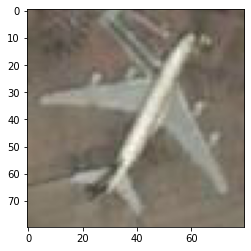

In [12]:
#Getting the lowest resolution image
d_name = 'Final_dataset'

for x,y in img_size_list:
    if y == (80, 80):
        print(x)
        im = load_img('/'.join([d_name, x]))
        plt.imshow(im)

This **80 X 80 pixel image is sufficient to classify the aircraft visually by humans**, so we are **standardizing our dataset** to the same resolution.

## **Preprocessing Steps:**
- Resizing
- Normalization

## 1. Resizing

In [13]:
W= 80 #Image Width
H = 80 #Image Height

def get_images(dir_name='Final_dataset', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
        #print("Cls", cls)
        
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            img = load_img('/'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)
            
            Images.append(img)
            Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.int)
    #Images, Classes = shuffle(Images, Classes, random_state=44)
    
    return Images, Classes

Getting images/labels

In [14]:
Images, Classes = get_images()

Images.shape, Classes.shape

((9385, 80, 80, 3), (9385,))

### Number of images in each class

In [15]:
unique, counts = np.unique(Classes, return_counts = True)
unique_count_list = list(zip(list(unique), list(counts)))

In [16]:
img_count = pd.DataFrame(unique_count_list, columns = ['class', 'ImgCount'])
class_names_count_df = pd.merge(img_count, class_to_label_df, on='class', how='outer')

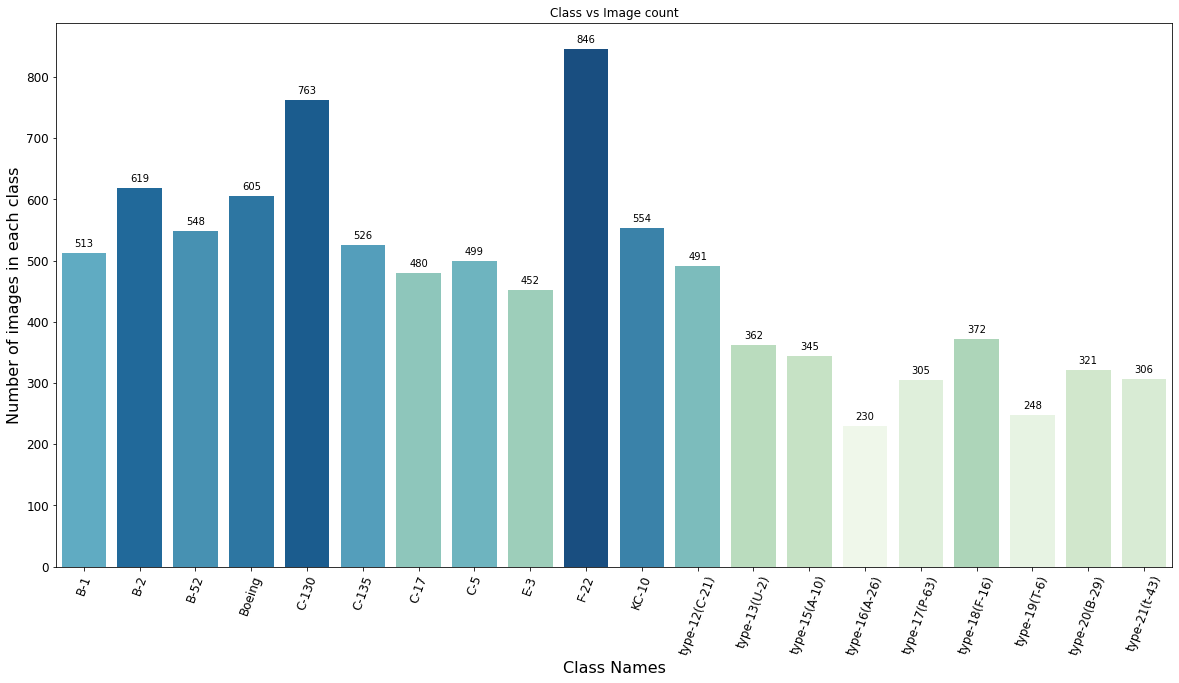

In [18]:
#Seaborn Barplot and it's arguments

plt.figure(figsize=(20, 10))
pal = sns.color_palette("GnBu_r", len(class_names_count_df))
rank = class_names_count_df["ImgCount"].argsort().argsort() 

#Barplot with count
plots = sns.barplot(x="className", y="ImgCount",data=class_names_count_df, palette=np.array(pal[::-1])[rank])
for index, row in class_names_count_df.iterrows():
  plots.text(x=index, y=row.ImgCount+10, s=row.ImgCount, color = 'black', ha = 'center', fontsize=10)

# Iterrating over the bars one-by-one
plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class Names", size=16)
  
# Setting the label for y-axis
plt.ylabel("Number of images in each class", size=16)
  
# Setting the title for the graph
plt.title("Class vs Image count")
  
# Fianlly showing the plot
plt.show()

## Hypothesis: 
- F-22, C-130, B-2, Boeing classes have more images than the rest, this can help in better prediction of these classes.
- type-16 (A-26), type-19(T-6) classes have lower number of images so may require augmentation or addition of more data to predict well.

Accordingly, we can design an autonomous or semi-autonomous aircraft tagging system. 

**Visualize images/lables for each class with**
- Class 
- Number of images in the class 
- Percentage of images in the class

B-1 513 5.47 %


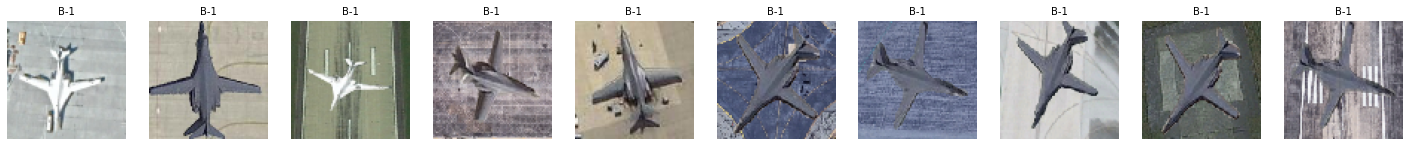

B-2 619 6.6 %


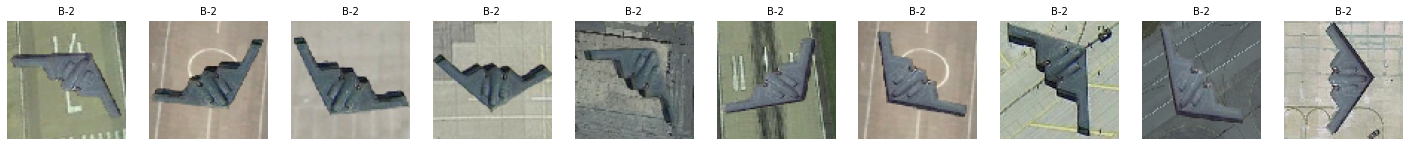

B-52 548 5.84 %


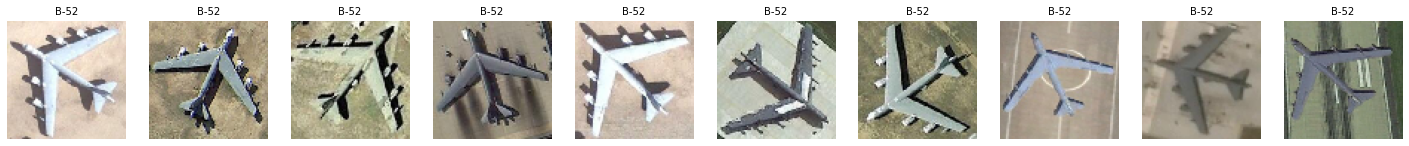

Boeing 605 6.45 %


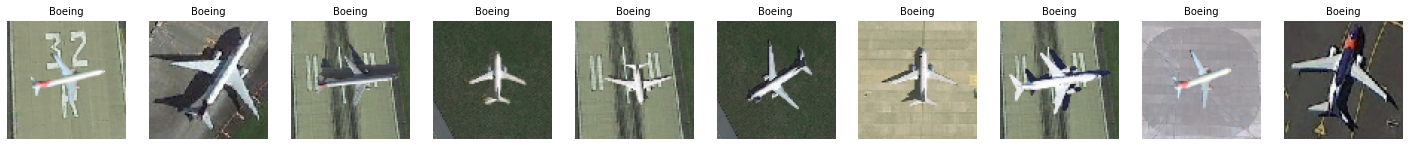

C-130 763 8.13 %


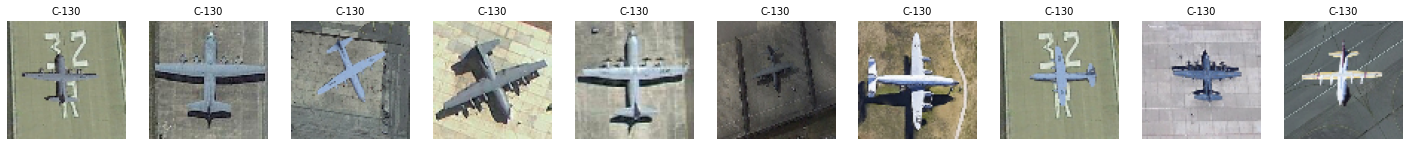

C-135 526 5.6 %


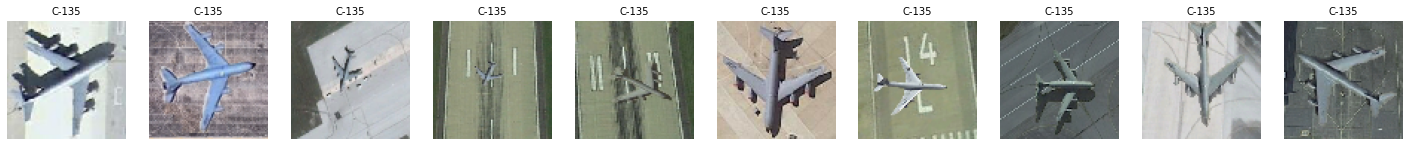

C-17 480 5.11 %


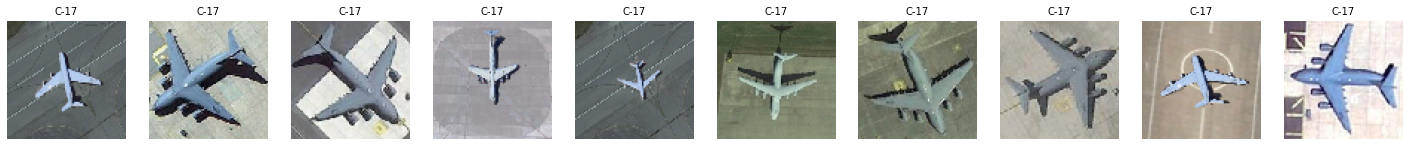

C-5 499 5.32 %


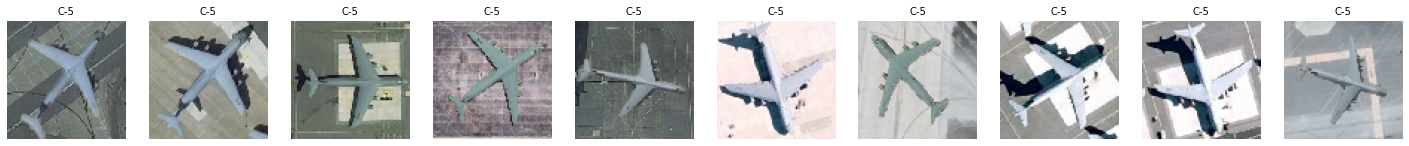

E-3 452 4.82 %


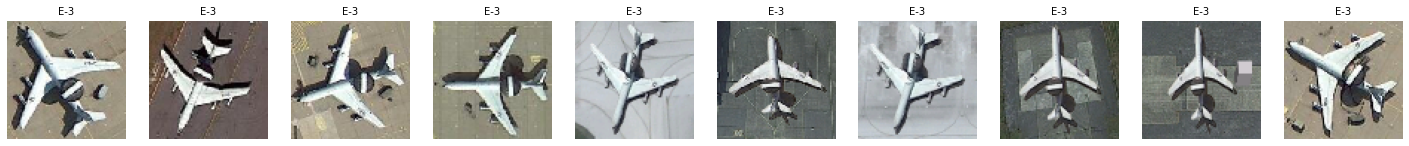

F-22 846 9.01 %


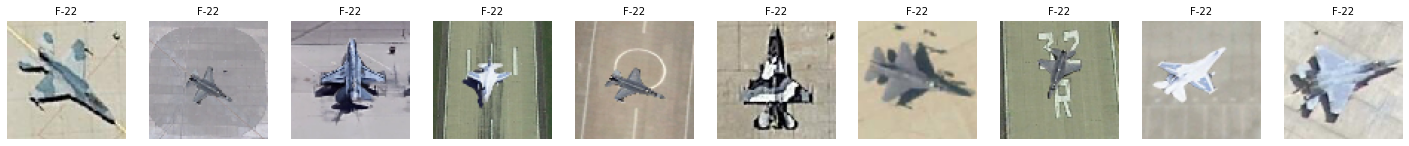

KC-10 554 5.9 %


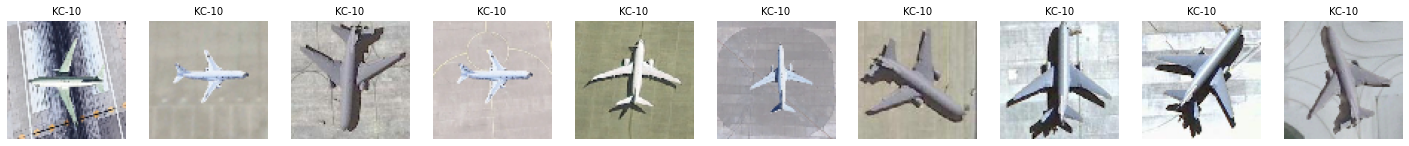

type-12(C-21) 491 5.23 %


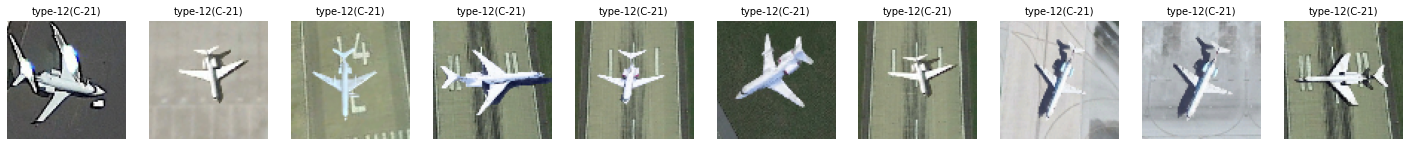

type-13(U-2) 362 3.86 %


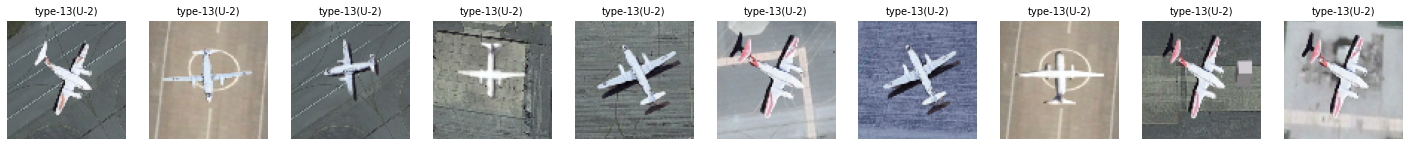

type-15(A-10) 345 3.68 %


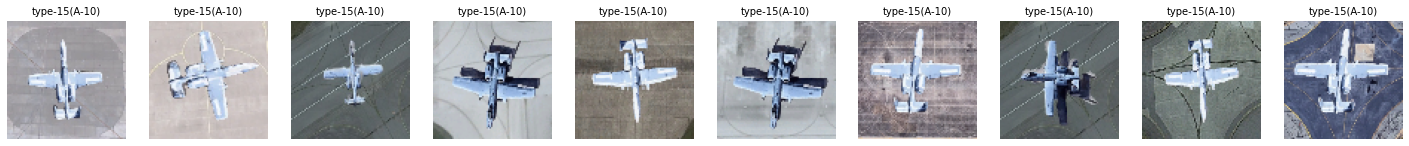

type-16(A-26) 230 2.45 %


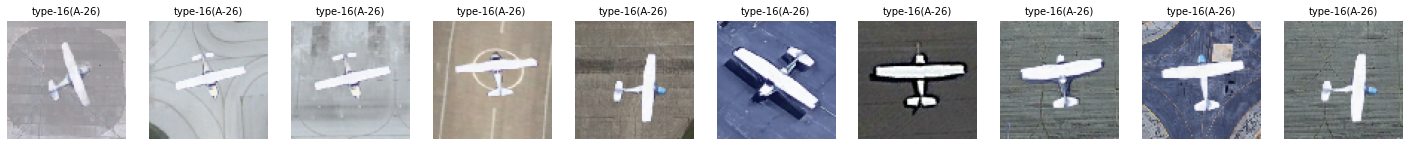

type-17(P-63) 305 3.25 %


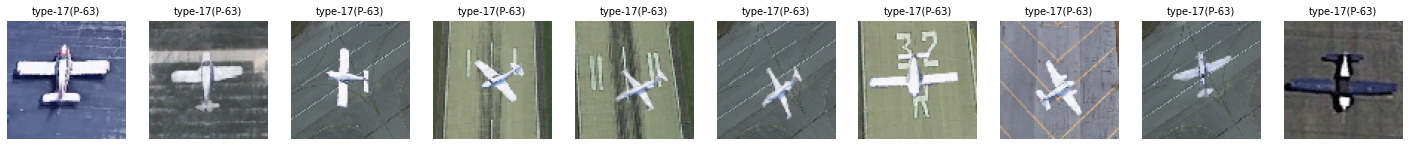

type-18(F-16) 372 3.96 %


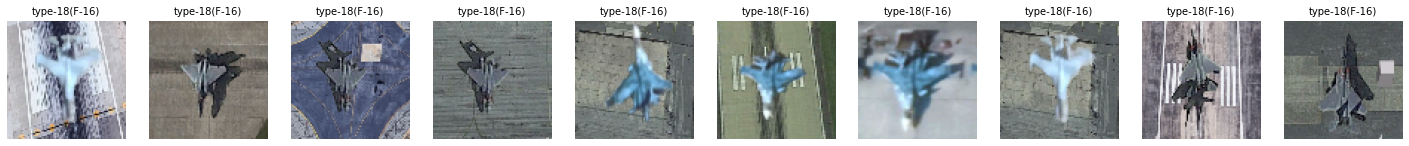

type-19(T-6) 248 2.64 %


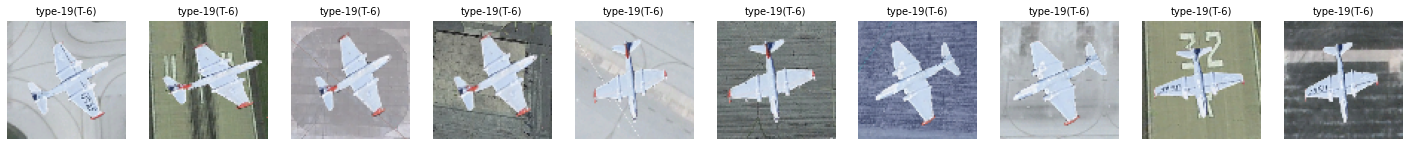

type-20(B-29) 321 3.42 %


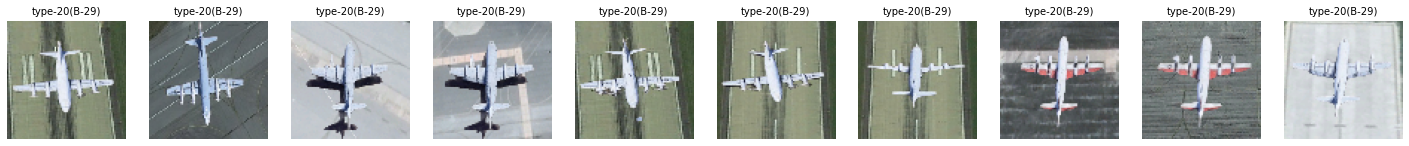

type-21(t-43) 306 3.26 %


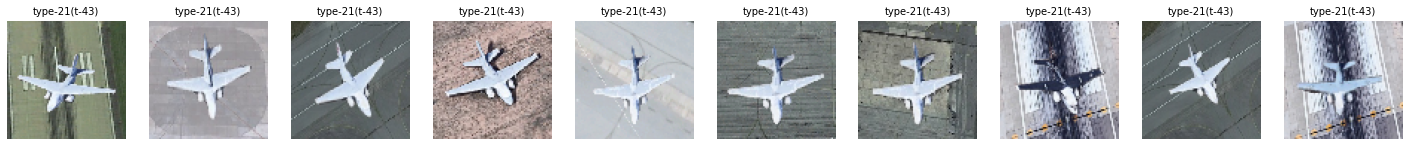

In [19]:
n_total_images = Images.shape[0]

for target_cls in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
    
    indices = np.where(Classes == target_cls)[0] # get target class indices on Images / Classes
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, round((n_target_cls/n_total_images) * 100, 2),'%')

    n_cols = 10 # # of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label, fontsize =10)

    plt.show()

In [20]:
Images.shape

(9385, 80, 80, 3)

## Split dataset into train, validation and test
Train: 7508
<br> Validation: 1501
<br> test : 376

Train Test Split ratio - 80: 20

In [21]:
x_train, x_val_test, y_train, y_val_test = train_test_split(Images, Classes, train_size=0.8, test_size=0.2, stratify=Classes, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, train_size=0.8, test_size=0.2, stratify=y_val_test, random_state=42)

In [22]:
#Shape of Train, Validation and Test
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((7508, 80, 80, 3),
 (7508,),
 (1501, 80, 80, 3),
 (1501,),
 (376, 80, 80, 3),
 (376,))

In [23]:
## categorical to one-hot
y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)
y_test = to_categorical(y_test, n_classes)

y_train.shape ,y_val.shape, y_test.shape #(7508, 20)

((7508, 20), (1501, 20), (376, 20))

## 2. Normalising input images

Scales values of the **pixels in 0-1 range**

> Normalizing train, validation and test images **separately** so there is n**o data/info leak.**



In [24]:
x_train /=255
x_val /=255
x_test /=255

## Model building 

> ### Hand Crafted Model 
1. The model consists of four blocks of convolution with 3X3 kernels with maxPooling layer connecting them 
2. Batch Normalization is used to normalize the image batches in each layer
3. ReLu activation is used to induce non-linearity to our model
4. We are using Padding to keep the image size consistent through the convolution block
5. In block 3, 128 features are extracted and flattened before passing it to the Fully Connected layer(FC layer/Dense layer) with 32 hidden units.
6. In Output layer, softmax activation is used to provide the probablities for 20 classes.
7. Dropout 0.2 provides a regularization effect by randomly dropping off 20% of the neurons in the FC layer.

Tried out:
- Squeeze and expand architecture by extracting [32 > 64> 128 > 256 features] in each convolutional block.
- Used 1X1 convolutions to reduce the number of channels. 
- Large number of features extracted from squueze and expand architecture, the model was heavy and number of trainable parameters increased.




In [25]:
# Initialise model
model = Sequential()

# Block 1
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(80, 80, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size =(2, 2)))

# Block 2
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size =(2, 2)))

# Block 3
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size =(2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Softmax
model.add(Dense(20, activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 80, 32)        9

## Model Training

1. **Loss funtion:** 'Categorical crossentropy' . Used in Multi-class classification tasks
2. **Optimizer:** 'Adam' derived from Adaptive moment estimation
3. **Metrics:** Accuracy, Precision, Recall
4. **LR scheduler** used reduces learning rate by a factor of 10 (lr/10) for every epoch after 10th epoch.
5. **Early stopping**: When the model performance isn't improving for two consecutive epochs, training is stopped and mode is saved.

##Hyperparamters used:
**learning rate** (lr = 0.0001)
<br>**batch size**  (batch size =16)
<br>**number of epochs** (epochs = 25)

In [27]:
# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy', 'Precision', 'Recall']
)

In [28]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * math.exp(-0.1)

In [29]:
working_dir = "drive/MyDrive/MTARSI/SavedModels/"
file_name = 'model.{epoch:02d}-{accuracy:.2f}.h5'

my_callbacks = [
    EarlyStopping(monitor = 'loss', patience=2),
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath= os.path.join(working_dir, 'firstModel', file_name), save_best_only=True), 
    TensorBoard(log_dir='./logs'),
]

In [30]:
print("Fit model on training data")
history = model.fit(x_train, y_train, epochs=25, batch_size=16, callbacks=my_callbacks, validation_data=(x_val, y_val))

Fit model on training data
Epoch 1/25
470/470 [==============================] - 65s 30ms/step - loss: 2.9761 - accuracy: 0.0871 - precision: 0.2093 - recall: 5.3354e-04 - val_loss: 2.8358 - val_accuracy: 0.0959 - val_precision: 1.0000 - val_recall: 0.0020
Epoch 2/25
470/470 [==============================] - 12s 25ms/step - loss: 2.6889 - accuracy: 0.1184 - precision: 0.8414 - recall: 0.0248 - val_loss: 2.5721 - val_accuracy: 0.1832 - val_precision: 0.9783 - val_recall: 0.0300
Epoch 3/25
470/470 [==============================] - 11s 24ms/step - loss: 2.5208 - accuracy: 0.1669 - precision: 0.8314 - recall: 0.0603 - val_loss: 2.3000 - val_accuracy: 0.2672 - val_precision: 0.9091 - val_recall: 0.1199
Epoch 4/25
470/470 [==============================] - 12s 25ms/step - loss: 2.2228 - accuracy: 0.2751 - precision: 0.8442 - recall: 0.1293 - val_loss: 1.9312 - val_accuracy: 0.4044 - val_precision: 0.9288 - val_recall: 0.1912
Epoch 5/25
470/470 [==============================] - 12s 25ms/st

### Plotting Model metrics

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

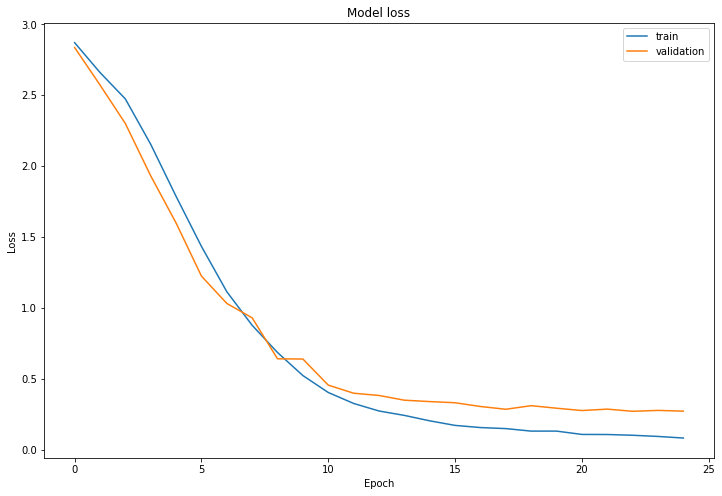

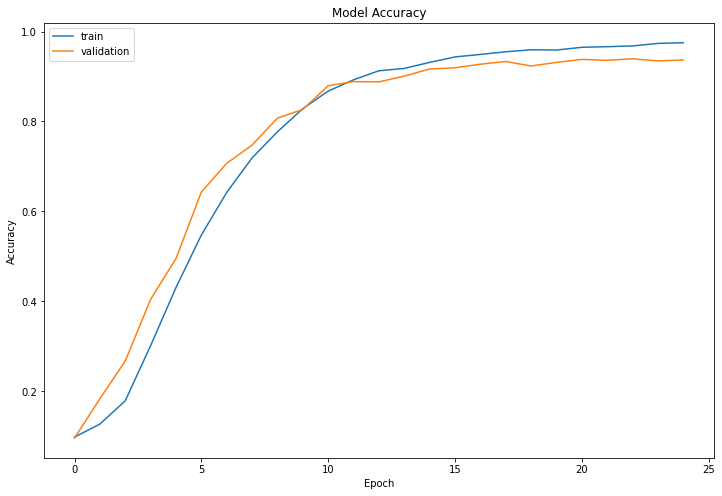

In [31]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

### Save the model as .h5 file

In [32]:
#Save model
model.save('drive/MyDrive/MTARSI/SavedModels/my_model_submission.h5')
print("model saved!!!")

model saved!!!


### Load the saved .h5 model file

In [34]:
#Load model
print("Model Loading...")
model = load_model('drive/MyDrive/MTARSI/SavedModels/my_model_submission.h5')
model.summary()

Model Loading...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80,

## Evaluating model performance on test data

In [35]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
24/24 [==============================] - 2s 17ms/step - loss: 0.3577 - accuracy: 0.9229 - precision: 0.9426 - recall: 0.9176
test loss, test acc: [0.3577408790588379, 0.9228723645210266, 0.9426229596138, 0.917553186416626]


In [36]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for all samples")
predictions = model.predict(x_test)
print("predictions shape:", predictions.shape)

Generate predictions for all samples
predictions shape: (376, 20)


In [37]:
x_test.shape, y_test.shape, predictions.shape

((376, 80, 80, 3), (376, 20), (376, 20))

## Misclassified Images

In [38]:
class_pred = []
pred_label = []
act_label= []
misclassified_img = []
for i in range(predictions.shape[0]):
  class_pred.append(predictions[i].argmax())
  pred_label.append(class_to_label[class_pred[i]])
  act_label.append(class_to_label[y_test[i].argmax()])
  if pred_label[i] != act_label[i]:
    misclassified_img.append(i)

In [39]:
print("Number of misclassified images",len(misclassified_img))

Number of misclassified images 29


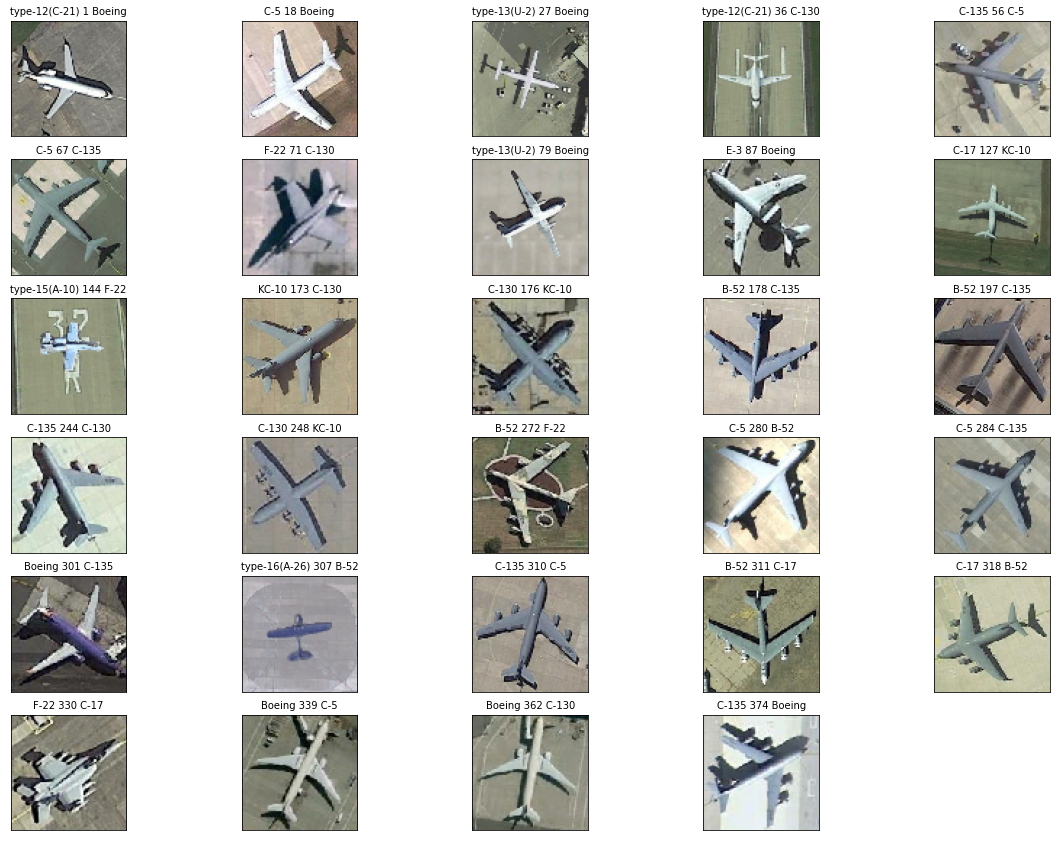

In [40]:
fig = plt.figure(figsize=(20, 20))

for i in range(len(misclassified_img)):
  ax = fig.add_subplot(8, 5, i+1,xticks=[], yticks=[])
  image = x_test[misclassified_img[i]]
  label_true = act_label[misclassified_img[i]]
  label_guess = pred_label[misclassified_img[i]]
  ax.imshow(image)
  ax.set_title("{} {:0.0f} {}".format(label_true, misclassified_img[i], label_guess), fontsize=10)


## Commonly misclassified classes:
- **C-135** (as B-52, Boeing) - classes are visually similar (4 engine aircrafts) - Manual tagging required. 
- **C-135, C130, C-5, C-17** (as **C-types, Boeing and Viceversa**)- All with **4 engines or long fuselage**
- **F-22** (similar to F-16), **(as C-types)**  - **Overfitting**
- **KC-10** (as C-type) - Need more images to train on
- **type-12(C-21)** (as other C-types) - Fuselage length and engine mounting differs




## Confusion Matrix
To visualize the performance of the model on the **predicted classes vs Ground Truth**. 

We can see, the **commonly confused classes are C-types aircrafts with KC-10, F-22 and Boeing**

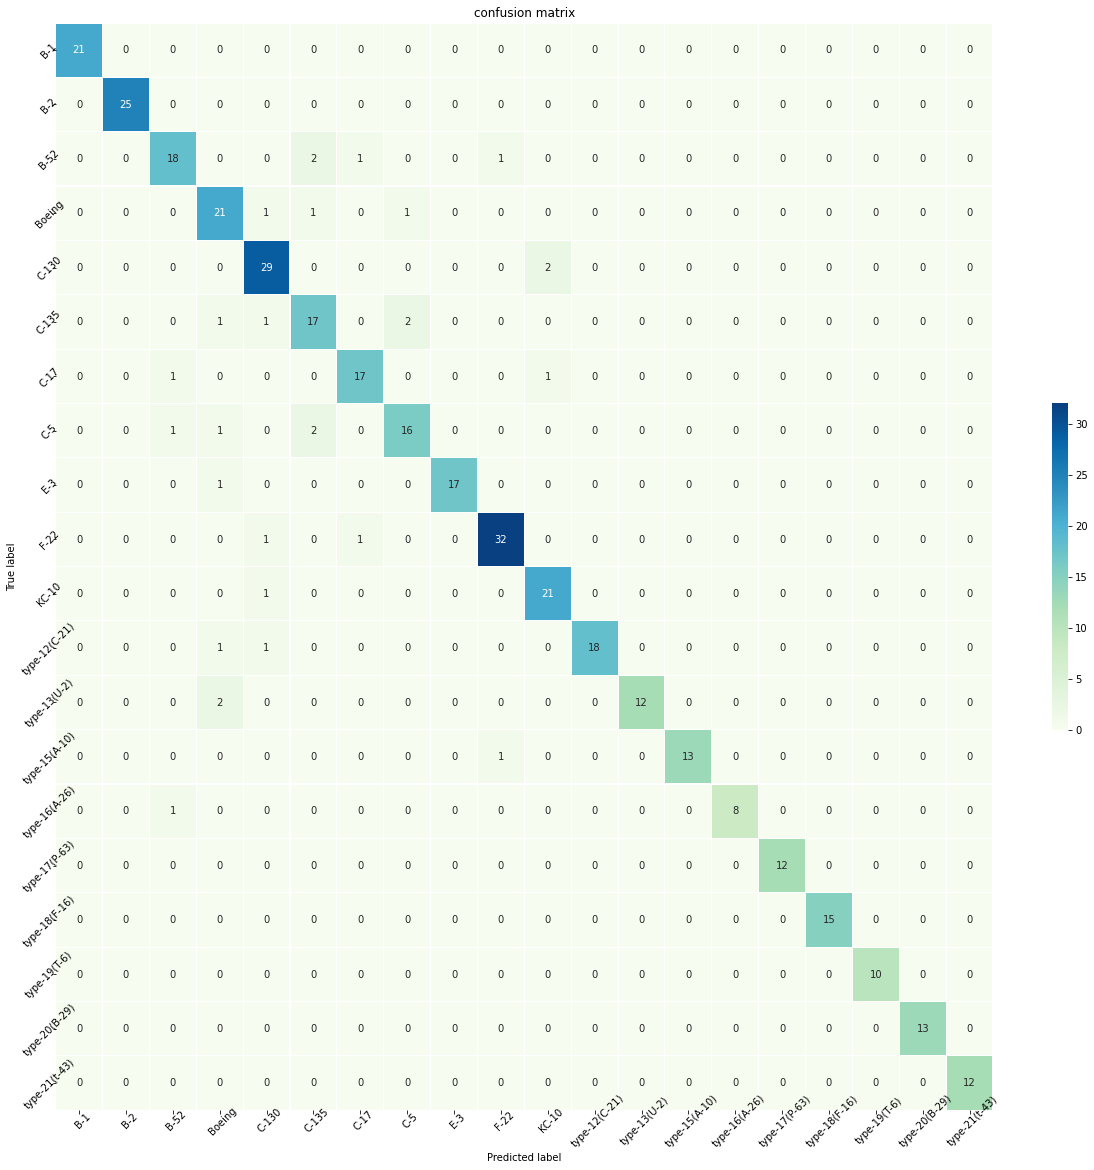

In [41]:
## plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis =1), class_pred)

fig, ax = plt.subplots(figsize=(21, 20))

sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

## GradCAM Implementation

To visualize the feaures learnt by the model and used for classification.

In [67]:
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [55]:
def get_img_array(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(80, 80))
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0) # Add one dimension to transform our array into a batch
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)
    
    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def create_superimposed_visualization(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * .9 + img
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return img, heatmap, superimposed_img

In [59]:
# We need to get the names of the last convolution layer of our model
last_conv_layer_name = 'batch_normalization_10'#'conv2d_10'

# We also need the names of all the layers that are part of the model head
classifier_layer_names = [
    'max_pooling2d_2', 'flatten','dense', 'dense_1'
] 

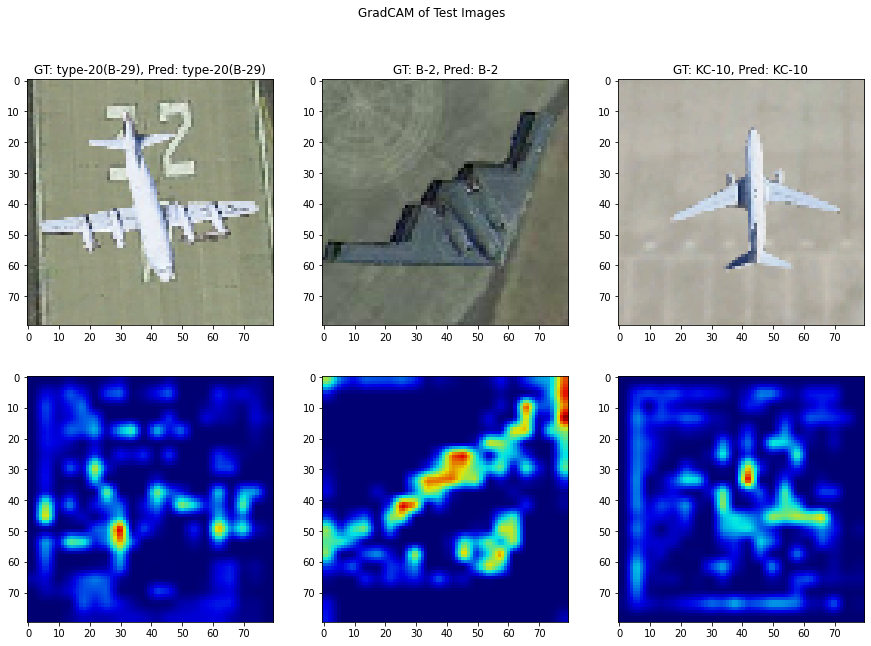

In [66]:
fig, ax = plt.subplots(figsize=(15, 10), ncols=3, nrows=2)

for i in range(3, 6):
    raw_image = x_test[i]

    image = np.expand_dims(raw_image, axis=0)

    heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name, classifier_layer_names)
    img, heatmap, superimposed_image = create_superimposed_visualization(raw_image, heatmap)

    ax[0][i-3].imshow(raw_image)
    ax[0][i-3].set_title('GT: {}, Pred: {}'.format(act_label[i], pred_label[i]))
    ax[1][i-3].imshow(superimposed_image)

fig.suptitle('GradCAM of Test Images')
plt.show()

## GradCAM for Misclassified Images

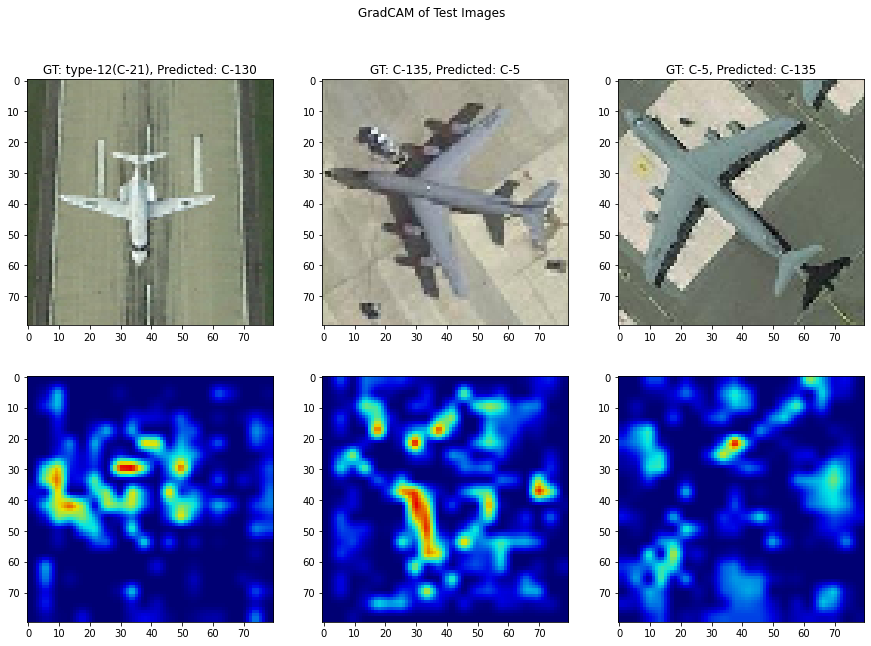

In [70]:
fig, ax = plt.subplots(figsize=(15, 10), ncols=3, nrows=2)

for i in range(3, 6):
    raw_image = x_test[misclassified_img[i]]

    image = np.expand_dims(raw_image, axis=0)

    heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name, classifier_layer_names)
    img, heatmap, superimposed_image = create_superimposed_visualization(raw_image, heatmap)

    label_true = act_label[misclassified_img[i]]
    label_guess = pred_label[misclassified_img[i]]
    ax[0][i-3].imshow(raw_image)
    ax[0][i-3].set_title('GT: {}, Predicted: {}'.format(label_true, label_guess))
    ax[1][i-3].imshow(superimposed_image)

fig.suptitle('GradCAM of Test Images')
plt.show()

**Model is confusing C-type aircrafts amongst themselves.**

In [76]:
#Class wise accuracy using classification report
Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
print(classification_report(Y_test, class_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        25
           2       0.86      0.82      0.84        22
           3       0.78      0.88      0.82        24
           4       0.85      0.94      0.89        31
           5       0.77      0.81      0.79        21
           6       0.89      0.89      0.89        19
           7       0.84      0.80      0.82        20
           8       1.00      0.94      0.97        18
           9       0.94      0.94      0.94        34
          10       0.88      0.95      0.91        22
          11       1.00      0.90      0.95        20
          12       1.00      0.86      0.92        14
          13       1.00      0.93      0.96        14
          14       1.00      0.89      0.94         9
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00        15
          17       1.00    

## Class-wise accuracy calculated from confusion matrix

In [88]:
#Class wise accuracy
matrix = confusion_matrix(np.argmax(y_test, axis =1), class_pred)
class_acc = ((matrix.diagonal()/matrix.sum(axis=1)) *100)
print((matrix.diagonal()/matrix.sum(axis=1)) *100)

[100.         100.          81.81818182  87.5         93.5483871
  80.95238095  89.47368421  80.          94.44444444  94.11764706
  95.45454545  90.          85.71428571  92.85714286  88.88888889
 100.         100.         100.         100.         100.        ]


In [90]:
class_names_count_df['Class_Accuracy'] = class_acc
class_names_count_df = class_names_count_df.round({"Class_Accuracy":2})
class_names_count_df.head()

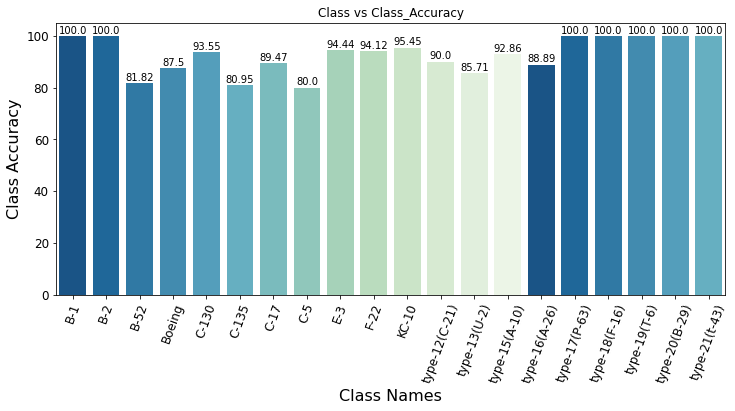

In [109]:
#Seaborn Barplot and it's arguments

plt.figure(figsize=(12, 5))
pal = sns.color_palette("GnBu_r", n_colors=len(set(class_names_count_df["Class_Accuracy"])))

#Barplot with count
plots = sns.barplot(x="className", y="Class_Accuracy",data=class_names_count_df, palette=pal)
for index, row in class_names_count_df.iterrows():
  plots.text(x=index, y=row.Class_Accuracy+1, s=row.Class_Accuracy, color = 'black', ha = 'center', fontsize=10)

# Iterrating over the bars one-by-one
plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class Names", size=16)
  
# Setting the label for y-axis
plt.ylabel("Class Accuracy", size=16)
  
# Setting the title for the graph
plt.title("Class vs Class_Accuracy")
  
# Fianlly showing the plot
plt.show()

# **Insights**

## **Top confident classes**: **Autonomous Prediction**
Classes that are predicted with **high confidence** by the model. The model can be **relied upon for accurate tagging without any manual intervention.**

- B-1
- B-2
- type-17(P-63)
- type-18(F-16)
- type-19(T-6)
- type-20(B-29)
- type-21(t-43) 

## **Medium Confidence (>90%) classes**: **Semi-Autonomous Prediction**
Model is predicting these classes with >90% confidence. So these can be included in the semi-autonomous prediction so model tagging can be reviewed by operator. 

- C-130
- E-3
- KC-10
- F-22
- type-15(A-10) 

### **Medium to Top Confidence class** - *Actions*:
1. Check on image quality followed by Data Augmentation 
2. Realistic synthetic data generation using GANs to generate more data and **retrain model**
3. Improve with Transfer learning and hyperparameter tuning
4. Implementation of ensemble methods
5. **F-22 - Overfitting** - Manually check the annotated labels and retrain with more data to generalize better.

## **Low Confidence Classes**: **Manual Tagging**
- B-52
- Boeing
- C-135
- C-17
- C-5
- type-12(C-21)
- type-13(U-2)
- type-16(A-26)

### **Low to Medium or Top Confidence class** - *Actions*:
1. **C category aircrafts** - Military Cargo aircrafts - Four engines, Large wing span - Visually Similar 
2. Depending on the business requirement, we can **group all C-type aircrafts as single category** to improve accuracy in tagging and bring it under Autonomous Prediction.
3. **B-52 Bomber Military aircrafts** (similar visually with 4 engines to C-types)can be considered to be of high importance to classify. So we can **collect more closer images** of the aircraft to help **model train better.**